### Training Script for CNN

The original Python script is adapted to a Jupyter Notebook to be trained and tested on Google Colab. The deployment of the model should not rely on this Notebook as it is inconsistent with the design of the system.

In [68]:
STOCK_NAME = "MSFT" # Change this before runnign
SAVE_MODEL = False # Testing mode

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import matplotlib
# matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

In [1]:
import pandas as pd, numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Custom Data Loading

Since this is just built as a training trigger, we do not intend to include complicated data processing helper functions. The `get_data` function is based on a function in helper.py but has been heavily modified to **work only in this specific context**.

In [51]:
def get_data(stock, scale=True):

    '''
    This modified version is only meant to work
    as a compromise for the CNN training notebook.
    It is designed to work well with CSV formats
    from Yahoo Finance API as well as Nasdaq
    '''

    df = pd.read_csv(f"{stock}.csv", header=0)
    df = df[1:].reset_index(drop=True) # drop the first row
    df.columns = df.columns.str.strip()

    # This parse dates in both 2024-09-11 and 09/11/2024 formats dynamically
    if df["Date"].dtype != "datetime64[ns]":
        # First, try parsing the default format (ISO 8601: YYYY-MM-DD)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # If any dates failed to parse, they will be NaT, so try parsing MM/DD/YYYY format for those
        if df['Date'].isna().any():
            df['Date'] = df['Date'].fillna(pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce'))

    # Handle certain csv with $ symbol before number
    for col in df.columns:

        if df[col].dtype == "object":
          df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

        # If adjusted closing is available it is preferred
        # Rename Adj Close to Close to make future references simpler
        if col == "Adj Close":
          df.drop(columns=["Close"], inplace=True)
          df.rename(columns={"Adj Close": "Close"}, inplace=True)

        elif col == "Volume":
          df.drop(columns=["Volume"], inplace=True)

        elif col == "Date" and df.index.name != "Date":
          df.index.name = "Date"
          df.set_index("Date", inplace=True)

        elif col == "Close/Last":
          df.rename(columns={"Close/Last": "Close"}, inplace=True)

    df['Return'] = df["Close"].pct_change()
    df["SMA"] = df["Close"].rolling(15).mean().shift()
    df["EMA"] = df["Close"].ewm(5).mean().shift()

    R = df.Return
    if scale:
        mean = df.mean(axis=0)
        std = df.std(axis=0)
        df = (df - mean) / std
    df['Return'] = R # Return is not scaled

    # The first 15 rows are removed as they contain NaN values
    # due to the computation of technical indicators

    return df[15:]


In [69]:
# Load the stock data
# data = pd.read_csv('AAPL_raw.csv', index_col='Date', parse_dates=True)
# data = get_data("GOOG", scale=False)

data = get_data(STOCK_NAME, scale=False)

# For this particular setup we don't use volumne nor return
labels = data["Close"].dropna()
data.drop(columns=["Return", "Close"], inplace=True)

print(data.head())
print(labels.head())

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(labels.values.reshape(-1, 1))

data = scaler.fit_transform(data)
labels = scaler.fit_transform(labels.values.reshape(-1, 1))

# Create the training and testing datasets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.4, train_size=0.6, shuffle=False)
test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.5, train_size=0.5, shuffle=False)

              Open    High       Low         SMA         EMA
Date                                                        
2024-08-16  420.60  421.34  417.3000  413.676667  417.772176
2024-08-15  419.80  421.11  417.6600  414.526667  417.895131
2024-08-14  414.80  417.72  412.4456  415.815333  418.442270
2024-08-13  409.59  414.95  409.5700  416.380000  418.168267
2024-08-12  407.06  408.76  404.2434  416.720667  417.452828
Date
2024-08-16    418.47
2024-08-15    421.03
2024-08-14    416.86
2024-08-13    414.01
2024-08-12    406.81
Name: Close, dtype: float64


In [61]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_data.shape)
print(val_labels.shape)

print(train_data[0])
print(train_labels[0])

(745, 5)
(248, 5)
(745, 1)
(248, 1)
(249, 5)
(249, 1)
[0.97689433 0.97977241 0.99159607 0.98592353 0.99434409]
[0.97230599]


In [70]:
# Create the training and testing sequences
def create_sequences(data, labels, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = labels[i + seq_length]
        X.append(_x)
        y.append(_y)
    return np.array(X), np.array(y)

seq_length = 10 # Two weeks of sequential data

# train_X will be a 3D array and train_y a 2D array
train_X, train_y = create_sequences(train_data, train_labels, seq_length)
test_X, test_y = create_sequences(test_data, test_labels, seq_length)
val_X, val_y = create_sequences(val_data, val_labels, seq_length)

In [63]:
print(train_X[0])
print(train_y[0])

[[0.97689433 0.97977241 0.99159607 0.98592353 0.99434409]
 [0.97665112 0.99327958 0.99622959 0.98947957 0.99522491]
 [0.96840383 0.98052403 0.98812093 0.99530313 0.99996922]
 [0.95060473 0.97499715 0.97680968 0.9968588  0.9995948 ]
 [0.94363986 0.94519759 0.95625412 0.99934159 1.        ]
 [0.92340858 0.94590501 0.94853158 1.         0.99531923]
 [0.90083357 0.92737963 0.92359234 0.99944373 0.99217839]
 [0.91328189 0.92779965 0.90573966 0.99809391 0.98636651]
 [0.8599288  0.9110207  0.88709201 0.99371603 0.97339942]
 [0.7987817  0.8688412  0.82383537 0.98978599 0.96468507]]
[0.88521064]


In [45]:
def create_model(n_features):

    # Define the CNN-DNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))  # Increased number of units
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))  # Added another dense layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')  # Reduced learning rate

    return model

model = create_model(5)

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 8, 64)               │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,777 (358.50 KB)

 Trainable params: 91,777 (358.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [71]:
# Train the model
model.fit(train_X, train_y, epochs=75, batch_size=32, validation_data=(val_X, val_y))  # Increased epochs

# Evaluate the model
loss = model.evaluate(test_X, test_y, verbose=0)
print('Test Loss:', loss)

Epoch 1/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8029e-04 - val_loss: 5.5473e-04
Epoch 2/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8430e-04 - val_loss: 5.8110e-04
Epoch 3/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4678e-04 - val_loss: 5.5850e-04
Epoch 4/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0657e-04 - val_loss: 5.8990e-04
Epoch 5/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9941e-04 - val_loss: 5.7504e-04
Epoch 6/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5521e-04 - val_loss: 6.4085e-04
Epoch 7/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8112e-04 - val_loss: 6.1298e-04
Epoch 8/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1934e-04 - val_loss: 6.3830e-04
Epoch 9/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8245e-04 - val_loss: 5.9787e-04
Epoch 10/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3309e-04 - val_loss: 6.0464e-04
Epoch 11/75
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6359e-04 - val

In [72]:
# Make predictions
predictions = model.predict(test_X)

if SAVE_MODEL: model.save("cnn_model.keras")

print(predictions[:5])
print(test_y[:5])

# Inverse transform the predictions to get the original scale
# Use the 'Close' feature scaler to inverse transform the predictions
predictions = close_scaler.inverse_transform(predictions)
test_y = close_scaler.inverse_transform(test_y.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[0.43644917]
 [0.4410003 ]
 [0.45237884]
 [0.44990277]
 [0.44500756]]
[[0.48046018]
 [0.47520351]
 [0.46607191]
 [0.457481  ]
 [0.45594906]]


### To be improved:

Currently, you can easily notice that the x-axis does not have the most informative label... What on Earth does _"Days since 2021-01-01"_ possibly mean! And honestly, we are not even sure of the date!

The cause of the issue has been diagnosed and identified to be the `train_test_split` function since it returns an `numpy ndarray` from a `pandas df`, effectively getting rid of the `"Date"` index.

> Before the script is released to final usage and integrated with the rest of the system, the problem should be addressed for consistent evaluation metrics.

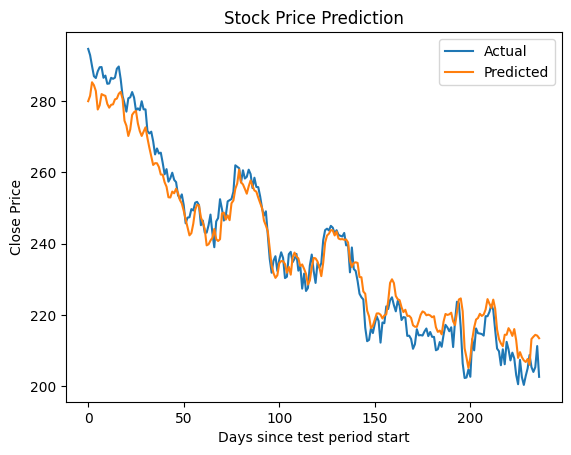

In [73]:
plt.plot(test_y, label='Actual')
plt.xlabel('Days since test period start')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.savefig('stock_price_prediction.png')
plt.ion()
# plt.pause(100)